# Imports

In [2]:
%matplotlib inline
import numpy as np
import pystan
import matplotlib.pylab as plt
import json
from scipy.stats.mstats import zscore

# Load data

#### Load

**`jj`**: Group for individual (*list*, `len(set(jj)) == 30`) <br>
**`y`**: Individual grade average (*list*, *prediction target*, `y.shape == (97, 1)`) <br>
**`x`**: Individual features (*list*, `x.shape == (97, 32)`) <br>
**`feature_labels`**: Feature names (*list*, `len(feature_labels) == 32`)

In [10]:
with open("data/jj.json", 'r') as fp:
    jj = np.array(json.load(fp)) + 1
with open("data/y.json", 'r') as fp:
    y = np.array(json.load(fp))
with open("data/x.json", 'r') as fp:
    x = np.array(json.load(fp))
with open("data/feature_labels.json", 'r') as fp:
    feature_labels = json.load(fp)

**Clean (remove nans)**

In [12]:
x_f, y_f, jj_f  = [], [], []
for _x, _y, _jj in zip(x, y, jj):
    if np.isnan(_y): continue
    x_f.append(_x.tolist())
    y_f.append(_y)
    jj_f.append(_jj)

x_f = zscore(np.nan_to_num(x_f))

x, y, jj = x_f, y_f, jj_f

**Append intersect at 1 to x for all individuals**

In [31]:
x = np.hstack([np.array([1]*x.shape[0]).reshape((-1, 1)), x])

# Analysis

## Simple hierarchical model

In [16]:
# USING EXAMPLE: ==== Hierarchical prior for means and variances in comparison of K groups ====
# SOURCE: https://github.com/avehtari/BDA_py_demos/blob/master/demos_pystan/pystan_demo.py
code = """
data {
    int<lower=0> N;                // number of data points 
    int<lower=0> K;                // number of groups 
    int<lower=1,upper=K> x[N];     // group indicator 
    vector[N] y;                   // grades 
}
parameters {
    real mu0;                      // hyper-prior mean 
    real<lower=0> sigma0;          // hyper-prior std 
    vector[K] mu;                  // group means 
    real<lower=0> sigma;           // common std 
}
model {
    mu0 ~ normal(mean(y), sd(y));  // weakly informative prior. NOTE: Here I use the empirical mean and SD of the data as hyper-prior parameters.
    sigma0 ~ normal(7, 4);         // weakly informative prior. NOTE: Here I have computed the mean and SD of the in-class SDs and used them as hyper-prior parameters.
    mu ~ normal(mu0, sigma0);      // population prior with unknown parameters.
    for (n in 1:N)
      y[n] ~ normal(mu[x[n]], sigma);
}
generated quantities {
    real y6_pred;
    y6_pred = normal_rng(mu[x[6]], sigma);
}
"""

data = dict(
    N = len(y),
    K = len(set(jj)),
    x = list(jj),
    y = y
)
# Compile and fit the model
fit = pystan.stan(model_code=code, data=data)

# Extract samples
samples = fit.extract(permuted=True)

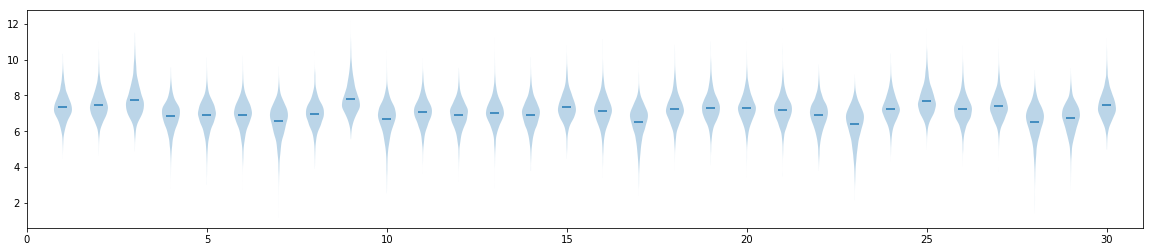

In [17]:
plt.figure(None, (20, 4))
plt.violinplot(samples['mu'], showmeans=True, showextrema=False)
plt.xlim([0, 31])
plt.show()

In [19]:
fit

Inference for Stan model: anon_model_8155d720e31ec5ee6ccf025220bb963f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu0       7.09    0.01   0.34   6.41   6.87   7.09   7.32   7.76  849.0    1.0
sigma0    0.83    0.03    0.4   0.25   0.52   0.79   1.09   1.74  208.0   1.03
mu[0]     7.35    0.01   0.77   5.89   6.87   7.31    7.8   9.03 4000.0    1.0
mu[1]     7.44    0.01   0.76   6.05   6.93   7.38   7.89   9.06 4000.0    1.0
mu[2]     7.75    0.03   0.93   6.17   7.11   7.63   8.27   9.94 1066.0   1.01
mu[3]     6.84    0.01   0.82   5.07   6.37    6.9   7.36   8.38 4000.0    1.0
mu[4]     6.89    0.01   0.84   5.03   6.43   6.94   7.42   8.44 4000.0    1.0
mu[5]     6.92    0.01   0.82    5.1   6.45   6.97   7.44   8.44 4000.0    1.0
mu[6]     6.57    0.03   0.95    4.4   6.04    6.7   7.22   8.16  812.0   1.01
mu[7]     6.96    0.0

## Hierarchical model regression

I don't use any group features because I have none. At this point at least, maybe it would make sense to have them later. I also tried using group features similarly to how it is done in the example where I only used arbitrary values between 0 and 1. It produced the same error then. I don't understand it.

In [39]:
# USING EXAMPLE: ==== 8.13. Multivariate Priors for Hierarchical Models ====
# SOURCE: Gelman 3rd, page 145
code = """
data {
    int<lower=0> N;                         // num individuals
    int<lower=1> K;                         // num ind predictors
    int<lower=1> J;                         // num groups
    int<lower=1> L;                         // num group predictors
    int<lower=1,upper=J> jj[N];             // group for individual
    matrix[N, K] x;                         // individual predictors
    row_vector[L] u[J];                     // group predictors
    vector[N] y;                            // outcomes
}
parameters {
    corr_matrix[K] Omega;                   // prior correlation
    vector<lower=0>[K] tau;                 // prior scale
    vector<lower=-10,upper=10>[K] beta[J];  // indiv coeffs by group
    real<lower=0> sigma;                    // prediction error scale
}
model {
    tau ~ cauchy(0, 2.5);
    Omega ~ lkj_corr(2);         
    
    beta ~ multi_normal(u, quad_form_diag(Omega, tau));
    
    for (n in 1:N)
        y[n] ~ normal(x[n] * beta[jj[n]], sigma);
}
"""

data = dict(
    N = len(y_f),
    K = x_f.shape[1],
    J = len(set(jj_f)),
    y = y_f + min(y_f) + 0.01,
    L = 1,
    jj = jj_f,
    x = zscore(x_f),
    u = [[np.random.random()] for _ in range(len(set(jj_f)))]
)

# Compile and fit the model
fit = pystan.stan(model_code=code, data=data)

# Extract samples
samples = fit.extract(permuted=True)

RuntimeError: Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 22: multi_normal_log: LDLT_Factor of covariance parameter is not positive definite. last conditional variance is 3.46945e-16.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 20: lkj_corr_log: y is not positive definite.
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Rejecting initial value:
  Error evaluating the log probability at the initial value.



Initialization between (-2, 2) failed after 100 attempts. 
 Try specifying initial values, reducing ranges of constrained values, or reparameterizing the model.
